# Test model on reader-specific questions
We have previously determined that the reader-aware model does (slightly) better on divisive posts.

How well does the model do on questions that are highly associated with a specific reader group? E.g. if P(reader == EXPERT) is high (based on classification model or reader traits), does the generation model catch those questions better?

In [12]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)

(53080, 17)


In [5]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))

In [6]:
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))

In [18]:
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

In [76]:
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.fit_transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })

In [74]:
## assign labels
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})

In [77]:
## predict class for all reader groups
import pandas as pd
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
pred_test_data = []
for reader_group_i in reader_groups:
    # clean data etc.
    test_data_i = test_data[test_data.loc[:, 'reader_group']==reader_group_i]
    question_post_text_i = np.hstack([np.vstack(test_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(test_data_i.loc[:, 'PCA_post_encoded'].values)])
    # do prediction!!
    reader_group_model_i = reader_group_models[reader_group_i]
    pred_prob_i = reader_group_model_i.predict_proba(question_post_text_i)
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred' : np.argmax(pred_prob_i, axis=1)
    })
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_prob' : np.max(pred_prob_i, axis=1)
    })
    pred_test_data.append(test_data_i)
pred_test_data = pd.concat(pred_test_data, axis=0)

In [78]:
## let's check out accuracy
from sklearn.metrics import f1_score
for reader_group_i, data_i in pred_test_data.groupby('reader_group'):
    print(f'label dist =\n{data_i.loc[:, "reader_group_class"].value_counts()}')
    print(f'pred dist =\n{data_i.loc[:, "reader_group_class_pred"].value_counts()}')
    f1_i = f1_score(data_i.loc[:, 'reader_group_class'].values, data_i.loc[:, 'reader_group_class_pred'].values, average='macro')
    print(f'reader group = {reader_group_i} has F1={"{:.3f}".format(f1_i)}')

label dist =
1    10070
0     4254
Name: reader_group_class, dtype: int64
pred dist =
0    8242
1    6082
Name: reader_group_class_pred, dtype: int64
reader group = expert_pct_bin has F1=0.463
label dist =
0    1459
1    1189
Name: reader_group_class, dtype: int64
pred dist =
0    1377
1    1271
Name: reader_group_class_pred, dtype: int64
reader group = location_region has F1=0.504
label dist =
0    8245
1    6079
Name: reader_group_class, dtype: int64
pred dist =
0    13338
1      986
Name: reader_group_class_pred, dtype: int64
reader group = relative_time_bin has F1=0.412


This is bad! Maybe there's an issue with data shift?

Let's retrain and test the model on balanced data.

In [126]:
## get train data, re-clean etc, combine with test data
train_data = torch.load('../../data/reddit_data/combined_data_train_data.pt').data.to_pandas()
train_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
## assign labels
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
train_data = train_data.assign(**{
    'reader_group' : train_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
train_data = train_data.assign(**{
    'reader_group_class' : train_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})
train_test_data = pd.concat([train_data, test_data], axis=0)
## add subreddit data for later sampling
import pandas as pd
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit'])
post_data.rename(columns={'id' : 'article_id'}, inplace=True)
train_test_data = pd.merge(train_test_data, post_data, on='article_id', how='left')

In [128]:
## recompute PCA etc.
trained_PCA_models = []
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
from sklearn.decomposition import PCA
embed_vars = ['question', 'post']
PCA_dim = 100
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(train_test_data.loc[:, embed_var_i].values, batch_size=32, device=torch.cuda.current_device(), show_progress_bar=True)
    train_test_data = train_test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
    # PCA transform
    PCA_model_i = PCA(n_components=PCA_dim, random_state=123)
    PCA_embed_i = PCA_model_i.fit_transform(np.vstack(train_test_data.loc[:, encode_var_i].values))
    train_test_data = train_test_data.assign(**{
        f'PCA_{encode_var_i}' : [PCA_embed_i[j, :] for j in range(PCA_embed_i.shape[0])]
    })

Batches:   0%|          | 0/8133 [00:00<?, ?it/s]

Batches:   0%|          | 0/8133 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [121]:
# check question nearest neighbors
sample_data = train_test_data.iloc[200, :]
print(sample_data.loc['question'])
sample_question_embed = sample_data.loc['PCA_question_encoded']
from sklearn.metrics.pairwise import cosine_similarity
sample_question_embed_sim = cosine_similarity(sample_question_embed.reshape(1,-1), np.vstack(train_test_data.loc[:, 'PCA_question_encoded'].values))
top_k = 10
top_k_sim_data = train_test_data.iloc[np.argsort(sample_question_embed_sim[0])[::-1][1:(top_k+1)], :]
display(top_k_sim_data.loc[:, 'question'])

I'm just confused why she even knows what your documents are?


174807    I'm just confused why she even knows what your...
134572    Does she have *any* documents with her real ag...
164758    Is there somewhere her father kept most of his...
136346    Is there somewhere her father kept most of his...
157111                     Do you not have those documents?
191358                     Do you not have those documents?
105907    Is she just forgetful and/or lazy, or is she t...
11449     Though she isn't curious where your entire che...
44601     Though she isn't curious where your entire che...
117364                 Sp have you actually read her stuff?
Name: question, dtype: object

OK! These representations are actually meaningful.

In [135]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
k_folds = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
layer_size = PCA_dim * 2
sample_size = 10000
for reader_group_i in reader_groups:
    data_i = train_test_data[train_test_data.loc[:, 'reader_group']==reader_group_i]
    # tmp debug
#     sample_size_i = min(sample_size, data_i.shape[0])
#     data_i = data_i.sample(sample_size_i, replace=False, random_state=123)
    # sample by subreddit
    subreddit_sample_size_i = data_i.loc[:, 'subreddit'].value_counts().min()
    sample_data_i = data_i.groupby('subreddit').apply(lambda x: x.sample(subreddit_sample_size_i, replace=False, random_state=123)).reset_index(drop=True)
    X = np.hstack([np.vstack(sample_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(sample_data_i.loc[:, 'PCA_post_encoded'].values)])
    Y = sample_data_i.loc[:, 'reader_group_class'].values
    acc_scores_i = []
    for j, (train_idx, test_idx) in tqdm(enumerate(k_folds.split(X, Y))):
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        model = MLPClassifier(hidden_layer_sizes=[layer_size,], activation='relu', solver='lbfgs', max_iter=1000, random_state=123)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        acc_score_j = (Y_pred==Y_test).sum() / len(Y_test)
        f1_score_j = f1_score(Y_test, Y_pred)
        print(f'iter {j} has acc={"{:.3f}".format(acc_score_j)} F1={"{:.3f}".format(f1_score_j)}')
        acc_scores_i.append([acc_score_j, f1_score_j])
    acc_scores_i = pd.DataFrame(acc_scores_i, columns=['acc', 'f1'])
    print(f'reader group {reader_group_i} has mean acc = {acc_scores_i.loc[:, "acc"].mean()}; F1={acc_scores_i.loc[:, "f1"].mean()}')

1it [02:03, 123.01s/it]

iter 0 has acc=0.523 F1=0.447


2it [03:50, 114.13s/it]

iter 1 has acc=0.540 F1=0.464


3it [05:39, 111.68s/it]

iter 2 has acc=0.512 F1=0.438


4it [07:21, 107.94s/it]

iter 3 has acc=0.528 F1=0.444


4it [07:48, 117.17s/it]


KeyboardInterrupt: 

This "train-from-scratch" approach isn't working out.

Why don't we just use the data that we used in the group classification model results? We balanced the data to have at least one question from each reader group per post.

In [1]:
# load sample data
import pandas as pd
import re
import numpy as np
arr_matcher = re.compile('[\[\]\n]')
embed_vars = ['question', 'post']
embed_var_converters = {
    f'PCA_{embed_var}_encoded': lambda x: np.fromstring(arr_matcher.sub('', x).strip(), sep=' ', dtype=float)
    for embed_var in embed_vars
}
post_question_data_file = '../../data/reddit_data/group_classification_model/sample_type=paired_post_question_data.gz'
post_question_data = pd.read_csv(post_question_data_file, sep='\t', compression='gzip', index_col=False,
                                 converters=embed_var_converters)
# fix author group
post_question_data = post_question_data.assign(**{
    'author_group' : post_question_data.loc[:, 'author_group'].apply(lambda x: str(x) if type(x) is not str else x)
})
# limit to test data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'article_id' : 'parent_id'}, inplace=True)
test_post_question_data = post_question_data[post_question_data.loc[:, 'parent_id'].isin(test_data.loc[:, 'parent_id'].unique())]
print(f'{test_post_question_data.shape[0]}/{post_question_data.shape[0]}')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


41132/209884


In [47]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
def resample_by_class(data, class_var='author_group', class_count='min'):
    data_class_counts = data.loc[:, class_var].value_counts()
#     print(f'data class counts = {data_class_counts}')
    if(class_count == 'min'):
        data_class_count_base = data_class_counts.min()
        data_class = data_class_counts.sort_values(ascending=True).index[0]
    elif(class_count == 'max'):
        data_class_count_base = data_class_counts.max()
        data_class = data_class_counts.sort_values(ascending=False).index[0]
#     print(f'min class = {data_min_class}')
    data = pd.concat(
        [data[data.loc[:, class_var]==data_class], 
         data[data.loc[:, class_var]!=data_class].sample(data_class_count_base, replace=(class_count=='max'), random_state=123)],
    axis=0)
#     print(f'post-stratify data class counts = {data.loc[:, class_var].value_counts()}')
    return data
np.random.seed(123)
text_var = 'PCA_question_encoded'
post_var = 'PCA_post_encoded'
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
n_folds = 5
reader_group_model_scores = []
train_pct = 0.8
for group_category_i, data_i in test_post_question_data.groupby('group_category'):
    Y = data_i.loc[:, 'author_group'].values
    default_class_i = reader_group_default_class[group_category_i]
    non_default_class_i = list(set(Y) - {default_class_i})[0]
    X = np.hstack([np.vstack(data_i.loc[:, text_var].values), np.vstack(data_i.loc[:, post_var].values)])
#     X = np.vstack(data_i.loc[:, text_var].values)
    layer_size = X.shape[1]
    # convert to binary
    Y = (Y==default_class_i).astype(int)
    # fit models across all folds
    model_scores = []
    k_folds = StratifiedKFold(n_splits=n_folds, random_state=123, shuffle=True)
    subreddits = data_i.loc[:, 'subreddit'].unique()
    data_i = data_i.assign(**{'idx' : list(range(data_i.shape[0]))})
    parent_id_i = data_i.loc[:, 'parent_id'].unique()
    train_N_i = int(len(parent_id_i) * train_pct)
    # split by parent ID
    for j in tqdm(range(n_folds)):
        train_id_j = set(np.random.choice(parent_id_i, train_N_i, replace=False))
        test_id_j = list(set(parent_id_i) - train_id_j)
        train_idx = np.where(data_i.loc[:, 'parent_id'].isin(train_id_j))[0]
        test_idx = np.where(data_i.loc[:, 'parent_id'].isin(test_id_j))[0]
    # k-fold splitting => need to prevent shared info from shared posts
#     for j, (train_idx, test_idx) in tqdm(enumerate(k_folds.split(X, Y))):
        # remove shared posts from test data
#         train_id_j = set(data_i.iloc[train_idx, :].loc[:, 'parent_id'].unique())
#         test_idx = list(set(test_idx) - set(np.where(data_i.loc[:, 'parent_id'].isin(train_id_j))[0]))
#         print(len(test_idx))
        # resample data to avoid class distribution imbalance
        train_data_i = data_i.iloc[train_idx, :]
        train_data_i = resample_by_class(train_data_i, class_var='author_group', class_count='max')
        train_idx = train_data_i.loc[:, 'idx'].values
        test_data_i = data_i.iloc[test_idx, :]
        test_data_i = resample_by_class(test_data_i, class_var='author_group', class_count='max')
        test_idx = test_data_i.loc[:, 'idx'].values
#         X_train = np.hstack([np.vstack(train_data_i.loc[:, text_var].values), np.vstack(train_data_i.loc[:, post_var].values)])
#         X_test = np.hstack([np.vstack(test_data_i.loc[:, text_var].values), np.vstack(test_data_i.loc[:, post_var].values)])
#         Y_train = (train_data_i.loc[:, 'author_group'].values==default_class_i).astype(int)
#         Y_test = (test_data_i.loc[:, 'author_group'].values==default_class_i).astype(int)
#         print(train_data_i.loc[:, 'author_group'].value_counts())
#         print(test_data_i.loc[:, 'author_group'].value_counts())
#         break
#         train_data_i_class_counts = train_data_i.loc[:, 'author_group'].value_counts()
#         train_data_i_min_class = train_data_i_class_counts.sort_values().index[0]
#         train_data_i = pd.concat(
#             [train_data_i[train_data_i.loc[:, 'author_group']==train_data_i_min_class], 
#              train_data_i[train_data_i.loc[:, 'author_group']!=train_data_i_min_class].sample(train_data_i_class_counts.min(), replace=False, seed=123)]
#         )
#         train_idx = train_data_i.loc[:, 'idx'].values
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
#         print(X_test.shape)
        
        # fit model
        model = MLPClassifier(hidden_layer_sizes=[layer_size,], activation='relu', max_iter=5000, random_state=123)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        Y_prob = model.predict_proba(X_test)
        model_acc = (Y_pred==Y_test).sum() / len(Y_test)
        # get F1 for both classes...there must be a better way to do this
        model_f1_class_1 = f1_score(Y_pred, Y_test)
        model_f1_class_0 = f1_score((1-Y_pred), (1-Y_test))
        model_f1_macro = f1_score(Y_pred, Y_test, average='macro')
        model_auc = roc_auc_score(Y_test, Y_prob[:, 1])
        model_scores_j = {
            'model_acc' : model_acc, 
            f'F1_{default_class_i}' : model_f1_class_1, 
            f'F1_{non_default_class_i}' : model_f1_class_0, 
            'F1_macro' : model_f1_macro,
            'AUC' : model_auc,
            'fold' : j}
        ## get scores per subreddit!!
        for subreddit_k in subreddits:
            idx_k = list(set(np.where(data_i.loc[:, 'subreddit']==subreddit_k)[0]) & set(test_idx))
            if(len(idx_k) > 0):
                Y_pred_k = model.predict(X[idx_k, :])
                model_acc_k = (Y[idx_k]==Y_pred_k).sum() / len(Y_pred_k)
                model_scores_j[f'model_acc_{subreddit_k}'] = model_acc_k
        model_scores_j['model_acc_subreddit_mean'] = np.mean([model_scores_j[f'model_acc_{subreddit_k}'] for subreddit_k in subreddits])
#         print(f'model scores = {model_scores_j}')
        model_scores.append(model_scores_j)
    model_scores = pd.DataFrame(model_scores)
    model_scores = model_scores.assign(**{'group_category' : group_category_i})
    print(f'reader group {group_category_i}')
    print(f'mean scores = {model_scores.loc[:, ["model_acc", "F1_macro", "model_acc_subreddit_mean"]].mean(axis=0)}')
    reader_group_model_scores.append(model_scores)
reader_group_model_scores = pd.concat(reader_group_model_scores, axis=0)

100%|██████████| 5/5 [01:45<00:00, 21.14s/it]


reader group expert_pct_bin
mean scores = model_acc                   0.499844
F1_macro                    0.450310
model_acc_subreddit_mean    0.555706
dtype: float64


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


reader group location_region
mean scores = model_acc                   0.516916
F1_macro                    0.503253
model_acc_subreddit_mean    0.526617
dtype: float64


100%|██████████| 5/5 [02:14<00:00, 26.96s/it]

reader group relative_time_bin
mean scores = model_acc                   0.506726
F1_macro                    0.502529
model_acc_subreddit_mean    0.505719
dtype: float64


### Label with trained models
Let's assume that the models are (slightly) more accurate for high-probability predictions. We will reload the trained models, recompute the representations for posts and questions, assign a reader group based on the model's prediction.

We will then cross-reference with the generated text from text-only and reader-aware models, and look at performance for the questions that were highly associated with a particular reader group.

In [1]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)

(53080, 17)


In [19]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.fit_transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })
## assign labels
category_reader_group_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in category_reader_group_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
pred_val_reader_group_lookup = {
    'relative_time_bin' : {
        0 : '<RESPONSE_TIME_1_AUTHOR>',
        1 : '<RESPONSE_TIME_0_AUTHOR>',
    },
    'expert_pct_bin' : {
        0 : '<EXPERT_PCT_1_AUTHOR>',
        1 : '<EXPERT_PCT_0_AUTHOR>',
    },
    'location_region' : {
        0 : '<US_AUTHOR>',
        1 : '<NONUS_AUTHOR>',
    },
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})
## predict class for all reader groups
import pandas as pd
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
pred_test_data = []
for reader_group_i in reader_groups:
    # clean data etc.
    test_data_i = test_data[test_data.loc[:, 'reader_group']==reader_group_i]
    question_post_text_i = np.hstack([np.vstack(test_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(test_data_i.loc[:, 'PCA_post_encoded'].values)])
    # do prediction!!
    reader_group_model_i = reader_group_models[reader_group_i]
    pred_prob_i = reader_group_model_i.predict_proba(question_post_text_i)
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred' : np.argmax(pred_prob_i, axis=1)
    })
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_prob' : np.max(pred_prob_i, axis=1)
    })
    # convert to class str
    pred_val_lookup_i = pred_val_reader_group_lookup[reader_group_i]
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_str' : test_data_i.loc[:, 'reader_group_class_pred'].apply(pred_val_lookup_i.get)
    })
    pred_test_data.append(test_data_i)
pred_test_data = pd.concat(pred_test_data, axis=0)

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

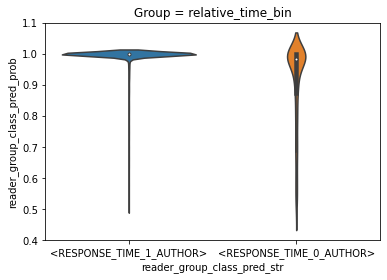

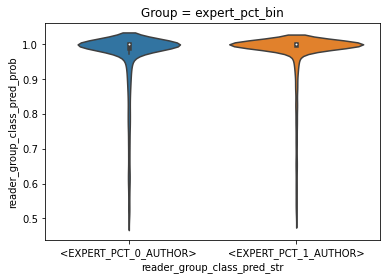

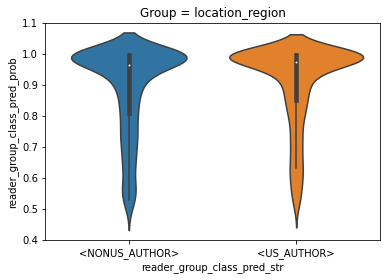

In [20]:
# show distribution of probability
# flatten data
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
for reader_group_i in reader_groups:
    data_i = pred_test_data[pred_test_data.loc[:, 'reader_group']==reader_group_i]
    sns.violinplot(data=data_i, x='reader_group_class_pred_str', y='reader_group_class_pred_prob')
    plt.title(f'Group = {reader_group_i}')
    plt.show()

Based on the skewed distributions, let's take the predictions with $P>=0.99$ and use those to filter the data.

In [23]:
pred_test_data.shape

(31296, 26)

In [24]:
prob_cutoff = 0.99
cutoff_test_data = pred_test_data[pred_test_data.loc[:, 'reader_group_class_pred_prob']>= prob_cutoff]
print(f'{cutoff_test_data.shape[0]}/{pred_test_data.shape[0]} data retained')

25101/31296 data retained


Will this data actually have different generation results, as compared to the full data? We will see!!

In [53]:
## load generated text data
import gzip
text_only_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_token_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))
reader_attention_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/author_attention_layer=5_location=encoder_config=attnconcat/test_data_output_text.gz', 'rt')))
test_data = test_data.assign(**{
    'text_only_model' : text_only_model_output,
    'reader_token_model' : reader_token_model_output,
    'reader_attn_model' : reader_attention_model_output,
})
# add to cutoff data
pred_text_data = pd.concat([cutoff_test_data, test_data.loc[cutoff_test_data.index, ['text_only_model', 'reader_token_model', 'reader_attn_model']]], axis=1)
print(pred_text_data.shape)

(25101, 29)


In [66]:
## compute overlap metrics etc.
from test_question_generation import STOP_WORDS, test_question_overlap
# suppress BLEU error message
import warnings
warnings.filterwarnings('ignore')
word_embed_file = '../../data/embeddings/wiki-news-300d-1M.vec.gz'
model_output_types = [
    'text_only_model',
    'reader_token_model',
    'reader_attn_model'
]
from nlp.arrow_dataset import Dataset
pred_text_data_torch = Dataset.from_pandas(pred_text_data)
pred_text_data_torch.rename_column_('question', 'target_text')
text_overlap_score_data = []
for model_output_type_i in model_output_types:
    print(f'model={model_output_type_i}')
    overlap_score_data_i = test_question_overlap(
        pred_text_data.loc[:, model_output_type_i].values,
        pred_text_data_torch,
        word_embed_file=word_embed_file,
        stop_words=STOP_WORDS,
    )
    # fix column names
    overlap_score_data_i.rename(columns={
        c : f'{c}_model={model_output_type_i.replace("_model","")}'
        for c in overlap_score_data_i.columns
    }, inplace=True)
    text_overlap_score_data.append(overlap_score_data_i)
text_overlap_score_data = pd.concat(text_overlap_score_data, axis=1)

What is the overall distribution of scores for the different model types?

BLEU-1_model=text_only              0.163296
ROUGE-L_model=text_only             0.130945
sentence_dist_model=text_only       0.725070
WMD_model=text_only                 0.235829
BLEU-1_model=reader_token           0.162543
ROUGE-L_model=reader_token          0.131450
sentence_dist_model=reader_token    0.728466
WMD_model=reader_token              0.236606
BLEU-1_model=reader_attn            0.159031
ROUGE-L_model=reader_attn           0.128210
sentence_dist_model=reader_attn     0.751031
WMD_model=reader_attn               0.245252
dtype: float64

,score_type,score,model_type
0,BLEU-1,0.104834,text_only
1,BLEU-1,0.133009,text_only
2,BLEU-1,0.210756,text_only
3,BLEU-1,0.105108,text_only
4,BLEU-1,0.242022,text_only


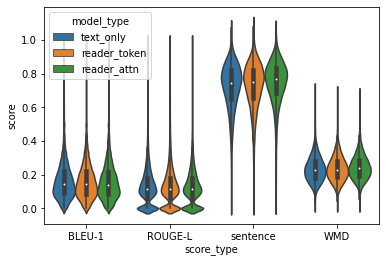

In [83]:
## print aggregate median vals
display(text_overlap_score_data.mean(axis=0))
## display distributions
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
flat_text_overlap_score_data = pd.melt(text_overlap_score_data, value_vars=text_overlap_score_data.columns, var_name='score_type', value_name='score')
flat_text_overlap_score_data = flat_text_overlap_score_data.assign(**{
    'model_type' : flat_text_overlap_score_data.loc[:, 'score_type'].apply(lambda x: x.split('=')[-1]),
    'score_type' : flat_text_overlap_score_data.loc[:, 'score_type'].apply(lambda x: x.split('_')[0]),
})
display(flat_text_overlap_score_data.head())
sns.violinplot(data=flat_text_overlap_score_data, x='score_type', y='score', hue='model_type')
plt.show()

Not great! What does this look like for different reader groups?

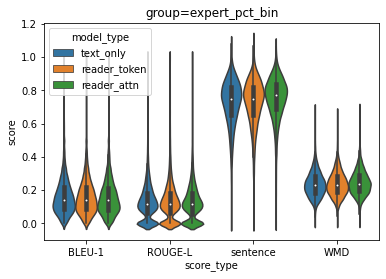

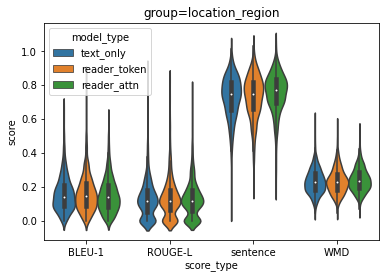

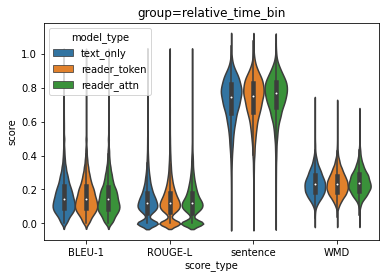

In [82]:
text_overlap_score_data.index = pred_text_data.index
pred_score_text_data = pd.concat([pred_text_data, text_overlap_score_data], axis=1)
## flatten etc
flat_pred_score_text_data = pd.melt(pred_score_text_data, id_vars=['reader_group'], value_vars=text_overlap_score_data.columns, var_name='score_type', value_name='score')
flat_pred_score_text_data = flat_pred_score_text_data.assign(**{
    'model_type' : flat_pred_score_text_data.loc[:, 'score_type'].apply(lambda x: x.split('=')[-1]),
    'score_type' : flat_pred_score_text_data.loc[:, 'score_type'].apply(lambda x: x.split('_')[0]),
})
# display(flat_pred_score_text_data.head())
for group_i, data_i in flat_pred_score_text_data.groupby('reader_group'):
    sns.violinplot(data=data_i, x='score_type', y='score', hue='model_type')
    plt.title(f'group={group_i}')
    plt.show()

### Train reader prediction model: per-subreddit
An "expert" user may look very different in one subreddit versus another. Let's try to address this by training a separate model for each reader group for each subreddit. $G*S=15$ models total...fun.

In [4]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)
## add subreddit info
import pandas as pd
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit']).rename(columns={'id' : 'article_id'})
test_data = pd.merge(test_data, post_data, on='article_id')
print(test_data.loc[:, 'subreddit'].value_counts())

(53080, 17)
AmItheAsshole      22531
personalfinance    11798
legaladvice         7424
Advice              7215
pcmasterrace        4112
Name: subreddit, dtype: int64


In [22]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })
## assign labels
category_reader_group_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in category_reader_group_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
pred_val_reader_group_lookup = {
    'relative_time_bin' : {
        0 : '<RESPONSE_TIME_1_AUTHOR>',
        1 : '<RESPONSE_TIME_0_AUTHOR>',
    },
    'expert_pct_bin' : {
        0 : '<EXPERT_PCT_1_AUTHOR>',
        1 : '<EXPERT_PCT_0_AUTHOR>',
    },
    'location_region' : {
        0 : '<US_AUTHOR>',
        1 : '<NONUS_AUTHOR>',
    },
}
# test_data = test_data.assign(**{
#     'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
# })
# fix reader var name
test_data.rename(columns={'reader_token_str' : 'author_group', 'article_id' : 'parent_id'}, inplace=True)
# fix reader var values
test_data = test_data.assign(**{'author_group' : })

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import train_test_reader_group_classification
np.random.seed(123)
question_data_combined_model_scores = []
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
text_var = 'PCA_question_encoded'
post_var = 'PCA_post_encoded'
reader_groups = set(test_data.loc[:, 'reader_group'].unique()) - {'UNK'}
reader_group_test_data = test_data[test_data.loc[:, 'reader_group'].isin(reader_groups)]
for subreddit_i, data_i in reader_group_test_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for reader_group_j, data_j in data_i.groupby('reader_group'):
        print(f'testing reader group = {reader_group_j}')
        default_group_class_j = reader_group_default_class[reader_group_j]
        model_scores_j = train_test_reader_group_classification(data_j, text_var=text_var, post_var=post_var)
        model_scores_j = model_scores_j.assign(**{
            'reader_group' : reader_group_j,
            'subreddit' : subreddit_i,
        })
        combined_model_scores.append(model_scores_j)
combined_model_scores = pd.concat(combined_model_scores, axis=0)

testing subreddit = Advice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


testing subreddit = AmItheAsshole
testing reader group = expert_pct_bin


100%|██████████| 10/10 [02:58<00:00, 17.88s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [02:17<00:00, 13.71s/it]


testing subreddit = legaladvice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [01:45<00:00, 10.51s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [01:26<00:00,  8.67s/it]


testing subreddit = pcmasterrace
testing reader group = expert_pct_bin


100%|██████████| 10/10 [00:53<00:00,  5.36s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [00:57<00:00,  5.78s/it]


testing subreddit = personalfinance
testing reader group = expert_pct_bin


100%|██████████| 10/10 [01:19<00:00,  7.94s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [01:29<00:00,  8.95s/it]


In [36]:
score_vars = ['model_acc', 'F1_class=1', 'F1_class=0', 'F1_macro', 'AUC']
per_subreddit_mean_combined_model_scores = combined_model_scores.groupby(['reader_group', 'subreddit']).apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(per_subreddit_mean_combined_model_scores)
# mean on all subreddits
mean_combined_model_scores = combined_model_scores.groupby('reader_group').apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(mean_combined_model_scores)

,reader_group,subreddit,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,Advice,0.498092,0.628729,0.224563,0.426646,0.502582
1,expert_pct_bin,AmItheAsshole,0.507100,0.620284,0.296443,0.458363,0.509524
2,expert_pct_bin,legaladvice,0.495956,0.602346,0.310876,0.456611,0.504757
3,expert_pct_bin,pcmasterrace,0.547577,0.631915,0.411572,0.521743,0.558143
4,expert_pct_bin,personalfinance,0.507897,0.626955,0.275558,0.451256,0.523585
5,location_region,Advice,0.498292,0.567337,0.396329,0.481833,0.500927
6,location_region,AmItheAsshole,0.510898,0.540417,0.459347,0.499882,0.506991
7,location_region,legaladvice,0.537581,0.393540,0.624653,0.509097,0.541916
8,location_region,pcmasterrace,0.532260,0.656421,0.260376,0.458399,0.749610
9,location_region,personalfinance,0.528611,0.303534,0.642648,0.473091,0.552832


,reader_group,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,0.511324,0.622046,0.303802,0.462924,0.519718
1,location_region,0.521528,0.492250,0.476671,0.484460,0.570455
2,relative_time_bin,0.508309,0.392619,0.584767,0.488693,0.515105


Let's compare this with question-only prediction.

In [37]:
question_data_combined_model_scores = []
for subreddit_i, data_i in reader_group_test_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for reader_group_j, data_j in data_i.groupby('reader_group'):
        print(f'testing reader group = {reader_group_j}')
        default_group_class_j = reader_group_default_class[reader_group_j]
        model_scores_j = train_test_reader_group_classification(data_j, text_var=text_var, post_var=None)
        model_scores_j = model_scores_j.assign(**{
            'reader_group' : reader_group_j,
            'subreddit' : subreddit_i,
        })
        question_data_combined_model_scores.append(model_scores_j)
question_data_combined_model_scores = pd.concat(question_data_combined_model_scores, axis=0)

testing subreddit = Advice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [03:51<00:00, 23.10s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [03:38<00:00, 21.82s/it]


testing subreddit = AmItheAsshole
testing reader group = expert_pct_bin


100%|██████████| 10/10 [06:00<00:00, 36.03s/it]


testing reader group = location_region


100%|██████████| 10/10 [01:22<00:00,  8.23s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [06:55<00:00, 41.51s/it]


testing subreddit = legaladvice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [03:51<00:00, 23.12s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:49<00:00,  4.91s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [03:46<00:00, 22.62s/it]


testing subreddit = pcmasterrace
testing reader group = expert_pct_bin


100%|██████████| 10/10 [03:08<00:00, 18.87s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [02:44<00:00, 16.46s/it]


testing subreddit = personalfinance
testing reader group = expert_pct_bin


100%|██████████| 10/10 [04:31<00:00, 27.12s/it]


testing reader group = location_region


100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [04:28<00:00, 26.81s/it]


In [38]:
score_vars = ['model_acc', 'F1_class=1', 'F1_class=0', 'F1_macro', 'AUC']
per_subreddit_mean_question_model_scores = question_data_combined_model_scores.groupby(['reader_group', 'subreddit']).apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(per_subreddit_mean_question_model_scores)
# mean on all subreddits
mean_question_model_scores = question_data_combined_model_scores.groupby('reader_group').apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(mean_question_model_scores)

,reader_group,subreddit,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,Advice,0.502788,0.619986,0.279057,0.449521,0.499977
1,expert_pct_bin,AmItheAsshole,0.516033,0.620268,0.331692,0.475980,0.523996
2,expert_pct_bin,legaladvice,0.507368,0.600827,0.354950,0.477888,0.523969
3,expert_pct_bin,pcmasterrace,0.579136,0.651391,0.468271,0.559831,0.589624
4,expert_pct_bin,personalfinance,0.502795,0.605367,0.327679,0.466523,0.510674
5,location_region,Advice,0.518171,0.587308,0.414926,0.501117,0.512395
6,location_region,AmItheAsshole,0.532392,0.577740,0.465840,0.521790,0.536454
7,location_region,legaladvice,0.523686,0.404276,0.600232,0.502254,0.511205
8,location_region,pcmasterrace,0.566329,0.682255,0.306767,0.494511,0.750971
9,location_region,personalfinance,0.529801,0.334111,0.634924,0.484518,0.561600


,reader_group,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,0.521624,0.619568,0.352330,0.485949,0.529648
1,location_region,0.534076,0.517138,0.484538,0.500838,0.574525
2,relative_time_bin,0.509501,0.425495,0.566503,0.495999,0.514016


The scores for the question-only model are slightly higher than the scores for the question + post model...this could indicate overfitting for the question + post model.

In [ ]:
## TODO: test model on different thresholds for "expert" vs. "novice", "fast" vs. "slow" readers

### Test model on "extreme" readers
We previously defined "experts" and "novices" based on a binary cutoff at 75% per-subreddit, and "fast" and "slow" responses at 50% per-subreddit. What if we restrict these categories to the most extreme members and look at the remaining questions? E.g. only look at "extreme" experts and novices.

In [1]:
## load original author data
import pandas as pd
from datetime import datetime
author_data = pd.read_csv('../../data/reddit_data/author_data/combined_author_prior_comment_data.gz', sep='\t', compression='gzip', converters={'date_day' : lambda x: datetime.strptime(x, '%Y-%m-%d') if x!='' else None})
display(author_data.head())
print(author_data.shape[0])

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,author,date_day,subreddit,expert_pct,relative_time,expert_pct_bin,relative_time_bin,age,location_self_id,location,location_region,subreddit_country,date_day_bin,text_embed,subreddit_embed
0,talosguideu,2019-06-05,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
1,talosguideu,2019-03-02,Advice,0.010101,6.265348,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
2,talosguideu,2019-03-30,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
3,talosguideu,2019-05-18,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
4,talosguideu,2019-05-24,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."


325229


Combine with question and post data, which we will use for classification.

In [12]:
## load question + post data
from datetime import datetime
question_data = pd.read_csv('../../data/reddit_data/combined_data_clean_question_data.gz', sep='\t', compression='gzip')
comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_filter_comment_question_data.gz', sep='\t', usecols=['id', 'created_utc'], converters={'created_utc' : lambda x: datetime.fromtimestamp(int(x))}).drop_duplicates('id')
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip').rename(columns={'id' : 'article_id'})
question_data = pd.merge(question_data, comment_data, on='id', how='left')
question_post_data = pd.merge(question_data, post_data.loc[:, ['article_id', 'selftext']], on='article_id').rename(columns={'selftext' : 'post'})
## convert question date => day
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import round_date_to_day
question_post_data = question_post_data.assign(**{
    'date_day' : question_post_data.loc[:, 'created_utc'].apply(lambda x: round_date_to_day(int(x.timestamp())))
})
## join with author data
question_author_data = pd.merge(question_post_data, 
                                author_data.loc[:, ['author', 'subreddit', 'date_day', 'expert_pct', 'relative_time']],
                                on=['author', 'subreddit', 'date_day'])
print(question_author_data.shape)
# fix column names
question_author_data.rename(columns={'source_text' : 'post', 'target_text' : 'question', 'article_id' : 'parent_id'}, inplace=True)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(144445, 22)


In [14]:
## compute sentence representations for post + question
from model_helpers import load_sentence_embed_model
from sklearn.decomposition import PCA
import numpy as np
import torch
sentence_embed_model = load_sentence_embed_model()
text_vars = ['question', 'post']
dim = 100
for text_var in text_vars:
    encoding_i = sentence_embed_model.encode(question_author_data.loc[:, text_var].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    question_author_data = question_author_data.assign(**{
        f'{text_var}_encoded' : [encoding_i[i, :] for i in range(encoding_i.shape[0])] 
    })
    ## compress via PCA
    PCA_model = PCA(n_components=dim)
    PCA_encoding_i = PCA_model.fit_transform(np.vstack(question_author_data.loc[:, f'{text_var}_encoded'].values))
    question_author_data = question_author_data.assign(**{
        f'PCA_{text_var}_encoded' : [PCA_encoding_i[i, :] for i in range(PCA_encoding_i.shape[0])]
    })

Batches:   0%|          | 0/9028 [00:00<?, ?it/s]

Batches:   0%|          | 0/9028 [00:00<?, ?it/s]

In [16]:
## combine encodings for prediction later
from tqdm import tqdm
tqdm.pandas()
question_author_data = question_author_data.assign(**{
    'PCA_question_post_encoded' : question_author_data.progress_apply(lambda x: np.hstack([x.loc['PCA_question_encoded'], x.loc['PCA_post_encoded']]), axis=1)
})

100%|██████████| 144445/144445 [00:31<00:00, 4569.39it/s]


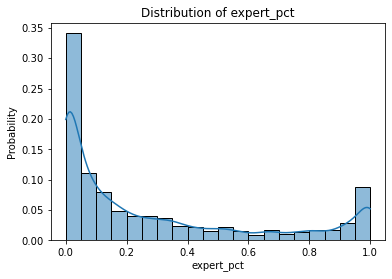

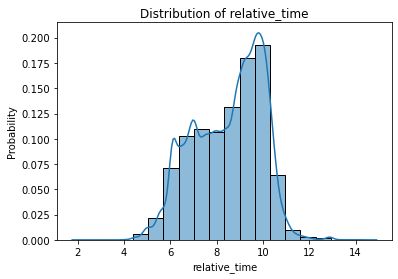

In [17]:
## look at data distributions for expert_pct and relative_time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
author_vars = ['expert_pct', 'relative_time']
for author_var_i in author_vars:
    sns.histplot(data=question_author_data, x=author_var_i, stat='probability', bins=20, kde=True)
    plt.title(f'Distribution of {author_var_i}')
    plt.show()

Let's experiment with some different cutoff values to determine how to identify groups with maximally different questions.

In [68]:
import numpy as np
pct_cutoffs = [10, 25, 50, 75, 90]
author_var_cutoff_data = []
for subreddit_i, data_i in question_author_data.groupby('subreddit'):
    for pct_cutoff_j in pct_cutoffs:
        for author_var_k in author_vars:
            cutoff_k = np.percentile(data_i.loc[:, author_var_k], pct_cutoff_j)
            cutoff_var_name_k = f'{author_var_k}>{pct_cutoff_j}'
            data_i = data_i.assign(**{
                cutoff_var_name_k : np.digitize(data_i.loc[:, author_var_k].values, [cutoff_k])
            })
    author_var_cutoff_data.append(data_i)
author_var_cutoff_data = pd.concat(author_var_cutoff_data, axis=0)

In [81]:
## save data to reboot GPU
author_var_cutoff_data.to_csv('../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz', sep='\t', compression='gzip', index=False)

In [82]:
!ls -halt ../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz

-rw-rw-r-- 1 ianbstew ianbstew 1.9G Oct 20 23:25 ../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz


How easily can a classifier differentiate the author groups for the different groups?

We'll try an aggregate approach first and then per-subreddit if that doesn't work.

In [2]:
# reload data
import pandas as pd
author_var_cutoff_data = pd.read_csv('../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz', sep='\t', compression='gzip')

In [51]:
## train, test
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import train_test_reader_group_classification
combined_text_var = 'PCA_question_post_encoded'
author_vars = ['expert_pct', 'relative_time']
cutoff_var_scores = []
acc_score_vars = ['model_acc', 'F1_macro', 'AUC']
for author_var_i in author_vars:
    print(f'testing author var = {author_var_i}')
    pct_cutoff_vars_i = list(filter(lambda x: x.startswith(author_var_i+'>'), author_var_cutoff_data.columns))
    for pct_cutoff_var_j in pct_cutoff_vars_i:
        ## train/test classifier
        print(f'testing cutoff var = {pct_cutoff_var_j}')
        cutoff_var_scores_j = train_test_reader_group_classification(author_var_cutoff_data, class_var=pct_cutoff_var_j,
                                                                     text_var=combined_text_var, post_var=None,
                                                                     subgroup_var=None)
        # compute means
        mean_cutoff_var_scores_j = cutoff_var_scores_j.loc[:, acc_score_vars].mean(axis=0)
        mean_cutoff_var_scores_j.loc['author_var_cutoff'] = pct_cutoff_var_j
        mean_cutoff_var_scores_j.loc['author_var'] = author_var_i
        cutoff_var_scores.append(mean_cutoff_var_scores_j)
cutoff_var_scores = pd.concat(cutoff_var_scores, axis=1).transpose()
display(cutoff_var_scores)

testing author var = expert_pct
testing cutoff var = expert_pct>10


100%|██████████| 10/10 [12:34<00:00, 75.44s/it]


testing cutoff var = expert_pct>25


100%|██████████| 10/10 [35:49<00:00, 214.93s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [1:02:27<00:00, 374.75s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [1:04:28<00:00, 386.83s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [1:04:11<00:00, 385.14s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [1:09:52<00:00, 419.24s/it]


,model_acc,F1_macro,AUC,author_var_cutoff,author_var
0,0.540275,0.419688,0.933436,expert_pct>10,expert_pct
1,0.535432,0.485231,0.602746,expert_pct>25,expert_pct
2,0.509309,0.508313,0.51421,expert_pct>50,expert_pct
3,0.508455,0.481266,0.514149,relative_time>10,relative_time
4,0.505772,0.478452,0.510212,relative_time>25,relative_time
5,0.505752,0.478838,0.512573,relative_time>50,relative_time


In [64]:
## train/test per subreddit
min_class_cutoff = 1000
subreddit_pred_scores = []
for subreddit_i, data_i in author_var_cutoff_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for author_var_j in author_vars:
        print(f'testing author var = {author_var_j}')
        pct_cutoff_vars_j = list(filter(lambda x: x.startswith(author_var_j+'>'), data_i.columns))
        for pct_cutoff_var_k in pct_cutoff_vars_j:
            ## train/test classifier
            if(data_i.loc[:, pct_cutoff_var_k].nunique() > 1 and data_i.loc[:, pct_cutoff_var_k].value_counts().min() > min_class_cutoff):
                print(f'testing cutoff var = {pct_cutoff_var_k}')
                cutoff_var_scores_k = train_test_reader_group_classification(data_i, class_var=pct_cutoff_var_k,
                                                                             text_var=combined_text_var, post_var=None,
                                                                             subgroup_var=None)
                # compute means
                mean_cutoff_var_scores_k = cutoff_var_scores_k.loc[:, acc_score_vars].mean(axis=0)
                mean_cutoff_var_scores_k.loc['author_var_cutoff'] = pct_cutoff_var_k
                mean_cutoff_var_scores_k.loc['author_var'] = author_var_j
                mean_cutoff_var_scores_k.loc['subreddit'] = subreddit_i
                subreddit_pred_scores.append(mean_cutoff_var_scores_k)
subreddit_pred_scores = pd.concat(subreddit_pred_scores, axis=1).transpose()

testing subreddit = Advice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:22<00:00, 32.28s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [04:12<00:00, 25.26s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [04:29<00:00, 26.96s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [04:40<00:00, 28.03s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [04:36<00:00, 27.63s/it]


testing subreddit = AmItheAsshole
testing author var = expert_pct
testing cutoff var = expert_pct>50


100%|██████████| 10/10 [10:27<00:00, 62.71s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [10:22<00:00, 62.30s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [09:52<00:00, 59.30s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [10:12<00:00, 61.26s/it]


testing subreddit = legaladvice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:17<00:00, 31.78s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [04:54<00:00, 29.47s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [04:50<00:00, 29.02s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [04:47<00:00, 28.76s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [04:47<00:00, 28.74s/it]


testing subreddit = pcmasterrace
testing author var = expert_pct
testing cutoff var = expert_pct>10


100%|██████████| 10/10 [02:33<00:00, 15.31s/it]


testing cutoff var = expert_pct>25


100%|██████████| 10/10 [02:59<00:00, 17.94s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [02:44<00:00, 16.48s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [02:46<00:00, 16.64s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [02:42<00:00, 16.28s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [02:45<00:00, 16.50s/it]


testing subreddit = personalfinance
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:17<00:00, 31.78s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [05:16<00:00, 31.63s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [05:28<00:00, 32.80s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [05:28<00:00, 32.90s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [05:30<00:00, 33.01s/it]


In [65]:
display(subreddit_pred_scores)

,model_acc,F1_macro,AUC,author_var_cutoff,author_var,subreddit
0,0.499739,0.443067,0.497541,expert_pct>25,expert_pct,Advice
1,0.518798,0.517028,0.524537,expert_pct>50,expert_pct,Advice
2,0.503592,0.452851,0.506605,relative_time>10,relative_time,Advice
3,0.498933,0.446414,0.50712,relative_time>25,relative_time,Advice
4,0.504838,0.454001,0.508914,relative_time>50,relative_time,Advice
5,0.504051,0.501617,0.505157,expert_pct>50,expert_pct,AmItheAsshole
6,0.496346,0.469584,0.490269,relative_time>10,relative_time,AmItheAsshole
7,0.494976,0.468008,0.493963,relative_time>25,relative_time,AmItheAsshole
8,0.496742,0.466796,0.49276,relative_time>50,relative_time,AmItheAsshole
9,0.51189,0.462141,0.523749,expert_pct>25,expert_pct,legaladvice


In [66]:
## just questions
## TODO: rerun with [75, 90]
min_class_cutoff = 1000
question_text_var = 'PCA_question_encoded'
subreddit_question_pred_scores = []
for subreddit_i, data_i in author_var_cutoff_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for author_var_j in author_vars:
        print(f'testing author var = {author_var_j}')
        pct_cutoff_vars_j = list(filter(lambda x: x.startswith(author_var_j+'>'), data_i.columns))
        for pct_cutoff_var_k in pct_cutoff_vars_j:
            ## train/test classifier
            if(data_i.loc[:, pct_cutoff_var_k].nunique() > 1 and data_i.loc[:, pct_cutoff_var_k].value_counts().min() > min_class_cutoff):
                print(f'testing cutoff var = {pct_cutoff_var_k}')
                cutoff_var_scores_k = train_test_reader_group_classification(data_i, class_var=pct_cutoff_var_k,
                                                                             text_var=question_text_var, post_var=None,
                                                                             subgroup_var=None)
                # compute means
                mean_cutoff_var_scores_k = cutoff_var_scores_k.loc[:, acc_score_vars].mean(axis=0)
                mean_cutoff_var_scores_k.loc['author_var_cutoff'] = pct_cutoff_var_k
                mean_cutoff_var_scores_k.loc['author_var'] = author_var_j
                mean_cutoff_var_scores_k.loc['subreddit'] = subreddit_i
                subreddit_question_pred_scores.append(mean_cutoff_var_scores_k)
subreddit_question_pred_scores = pd.concat(subreddit_question_pred_scores, axis=1).transpose()

testing subreddit = Advice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [08:39<00:00, 51.98s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [08:36<00:00, 51.64s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [08:48<00:00, 52.85s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [09:02<00:00, 54.21s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [09:02<00:00, 54.29s/it]


testing subreddit = AmItheAsshole
testing author var = expert_pct
testing cutoff var = expert_pct>50


100%|██████████| 10/10 [41:08<00:00, 246.84s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [41:58<00:00, 251.81s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [42:30<00:00, 255.06s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [42:06<00:00, 252.66s/it]


testing subreddit = legaladvice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [10:17<00:00, 61.75s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [09:33<00:00, 57.36s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [09:01<00:00, 54.17s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [09:05<00:00, 54.53s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [10:17<00:00, 61.80s/it]


testing subreddit = pcmasterrace
testing author var = expert_pct
testing cutoff var = expert_pct>10


100%|██████████| 10/10 [03:40<00:00, 22.07s/it]


testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:03<00:00, 30.38s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [04:53<00:00, 29.38s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [04:20<00:00, 26.07s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [04:43<00:00, 28.31s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [04:34<00:00, 27.41s/it]


testing subreddit = personalfinance
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [12:05<00:00, 72.56s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [12:29<00:00, 74.91s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [13:45<00:00, 82.57s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [13:25<00:00, 80.55s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [13:16<00:00, 79.61s/it]


In [67]:
display(subreddit_question_pred_scores)

,model_acc,F1_macro,AUC,author_var_cutoff,author_var,subreddit
0,0.498153,0.466133,0.499057,expert_pct>25,expert_pct,Advice
1,0.511217,0.509677,0.517154,expert_pct>50,expert_pct,Advice
2,0.504475,0.476548,0.497513,relative_time>10,relative_time,Advice
3,0.500024,0.471722,0.49854,relative_time>25,relative_time,Advice
4,0.501922,0.47312,0.498504,relative_time>50,relative_time,Advice
5,0.502294,0.501711,0.502501,expert_pct>50,expert_pct,AmItheAsshole
6,0.495032,0.477975,0.490585,relative_time>10,relative_time,AmItheAsshole
7,0.494389,0.476841,0.492198,relative_time>25,relative_time,AmItheAsshole
8,0.497816,0.480937,0.495301,relative_time>50,relative_time,AmItheAsshole
9,0.512524,0.483496,0.518569,expert_pct>25,expert_pct,legaladvice


These scores are pretty low! Let's try using a regular BOW representation to see if we can get stronger signals from the training data.

In [4]:
## TODO: use BoW + SVM
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from stop_words import get_stop_words
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
def train_test_BOW_model(data, text_var, class_var):
    tokenizer = WordPunctTokenizer()
    en_stops = get_stop_words('en')
    cv = CountVectorizer(min_df=0.001, max_df=0.5, stop_words=en_stops, tokenizer=tokenizer.tokenize)
    dtm = cv.fit_transform(data.loc[:, text_var].values)
    vocab = list(sorted(cv.vocabulary_, key=cv.vocabulary_.get))
    n_folds = 10
    k_fold = StratifiedKFold(n_folds)
    Y = data.loc[:, class_var].values
    model_scores = []
    for train_idx, test_idx in k_fold.split(dtm, Y):
        X_train, X_test = dtm[train_idx, :], dtm[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        model = SVC(C=1., kernel='rbf', probability=True)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        Y_prob = model.predict_proba(X_test)
        acc = (Y_test==Y_pred).sum() / len(Y_test)
        f1 = f1_score(Y_test, Y_pred, average='macro')
        auc = roc_auc_score(Y_test, Y_prob[:, 1])
        model_scores.append([acc, f1, auc])
    model_scores = pd.DataFrame(model_scores, columns=['acc', 'F1', 'AUC'])
    mean_model_scores = model_scores.mean(axis=0)
    return mean_model_scores

In [10]:
text_var = 'question'
per_subreddit_bow_model_scores = []
author_vars = ['expert_pct', 'relative_time']
min_class_cutoff = 1000
for subreddit_i, data_i in author_var_cutoff_data.groupby('subreddit'):
    print(f'subreddit = {subreddit_i}')
    for author_var_j in author_vars:
        print(f'testing author var = {author_var_j}')
        pct_cutoff_vars_j = list(filter(lambda x: x.startswith(author_var_j+'>'), data_i.columns))
        for pct_cutoff_var_k in pct_cutoff_vars_j:
            if(data_i.loc[:, pct_cutoff_var_k].nunique() > 1 and data_i.loc[:, pct_cutoff_var_k].value_counts().min() > min_class_cutoff):
                print(f'cutoff = {pct_cutoff_var_k}')
                model_scores_i = train_test_BOW_model(data_i, text_var, pct_cutoff_var_k)
                model_scores_i.loc['subreddit'] = subreddit_i
                model_scores_i.loc['author_var_cutoff'] = pct_cutoff_var_k
                model_scores_i.loc['author_var'] = author_var_j
                print(model_scores_i)
                per_subreddit_bow_model_scores.append(model_scores_i)
per_subreddit_bow_model_scores = pd.concat(per_subreddit_bow_model_scores, axis=1).transpose()

subreddit = Advice
testing author var = expert_pct
cutoff = expert_pct>25


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                       0.744441
F1                        0.433846
AUC                       0.505892
subreddit                   Advice
author_var_cutoff    expert_pct>25
author_var              expert_pct
dtype: object
cutoff = expert_pct>50


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                       0.509929
F1                        0.504267
AUC                       0.517511
subreddit                   Advice
author_var_cutoff    expert_pct>50
author_var              expert_pct
dtype: object
cutoff = expert_pct>75


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                       0.748494
F1                        0.454521
AUC                       0.524711
subreddit                   Advice
author_var_cutoff    expert_pct>75
author_var              expert_pct
dtype: object
cutoff = expert_pct>90


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504682
subreddit                      Advice
author_var_cutoff    relative_time>10
author_var              relative_time
dtype: object
cutoff = relative_time>25


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504686
subreddit                      Advice
author_var_cutoff    relative_time>25
author_var              relative_time
dtype: object
cutoff = relative_time>50


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504688
subreddit                      Advice
author_var_cutoff    relative_time>50
author_var              relative_time
dtype: object
cutoff = relative_time>75


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504686
subreddit                      Advice
author_var_cutoff    relative_time>75
author_var              relative_time
dtype: object
cutoff = relative_time>90


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


KeyboardInterrupt: 

In [79]:
display(per_subreddit_bow_model_scores)

acc    0.898407
F1     0.480710
AUC    0.509580
dtype: float64
Advice


In [ ]:
## TODO: use buffers e.g. expert_pct < 50-10 => "novice" and expert_pct > 50+10 => "expert"

In [ ]:
## TODO: increase min post count for inferring expert, relative time info

### Test models on reader-specific questions: per-subreddit models
We have updated the reader group classification task to generate a separate model for every subreddit.

Let's see if these models do a better job at identifying questions with high likelihood of being written by specific reader groups!

Note: we will have to load $M$ subreddits * $G$ reader groups = $15$ models to get this to work. Yikes!!

In [41]:
## load test data, subreddits, etc.
import torch
import pandas as pd
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas().drop(['source_ids', 'target_ids', 'attention_mask', 'subreddit_embed', 'text_embed', 'source_ids_reader_token', 'source_text_reader_token'], axis=1)
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit']).rename(columns={'id' : 'article_id'})
test_data = pd.merge(test_data, post_data, on='article_id')
## add reader group categories
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
# fix column names
test_data.rename(columns={'reader_token_str' : 'reader_group', 'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
test_data = test_data.assign(**{
    'group_category' : test_data.loc[:, 'reader_group'].apply(reader_group_category_lookup.get)
})
print(test_data.loc[:, 'subreddit'].value_counts())
print(test_data.loc[:, ['subreddit', 'group_category']].value_counts().sort_index())

AmItheAsshole      22531
personalfinance    11798
legaladvice         7424
Advice              7215
pcmasterrace        4112
Name: subreddit, dtype: int64
subreddit        group_category   
Advice           UNK                   1625
                 expert_pct_bin        2583
                 location_region        424
                 relative_time_bin     2583
AmItheAsshole    UNK                  12072
                 expert_pct_bin        4747
                 location_region        965
                 relative_time_bin     4747
legaladvice      UNK                   1789
                 expert_pct_bin        2597
                 location_region        441
                 relative_time_bin     2597
pcmasterrace     UNK                    833
                 expert_pct_bin        1516
                 location_region        247
                 relative_time_bin     1516
personalfinance  UNK                   5465
                 expert_pct_bin        2881
                 l

In [44]:
## compute sentence embeddings, compress via PCA, etc.
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
model_home_dir = '../../data/reddit_data/group_classification_model/'
PCA_question_embed_model = pickle.load(open(os.path.join(model_home_dir, 'PCA_model_embed=question_encoded.pkl'), 'rb'))
PCA_post_embed_model = pickle.load(open(os.path.join(model_home_dir, 'PCA_model_embed=post_encoded.pkl'), 'rb'))
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })
# combine representations
import numpy as np
test_data = test_data.assign(**{
    'PCA_question_post_encoded' : test_data.apply(lambda x: np.hstack([x.loc['PCA_question_encoded'], x.loc['PCA_post_encoded']]), axis=1)
})

In [50]:
## save data, reboot notebook, reload
test_data.to_csv('../../data/reddit_data/combined_data_test_data_encoding.gz', sep='\t', compression='gzip', index=False)

In [29]:
##
import pandas as pd
test_data = pd.read_csv('../../data/reddit_data/combined_data_test_data_encoding.gz', sep='\t', compression='gzip')
# fix format for post/question encoding
import numpy as np
from ast import literal_eval
import re
def str2array(s):
    # Remove space after [
    s=re.sub('\[ +', '[', s.strip())
    # Replace commas and spaces
    s=re.sub('[,\s]+', ', ', s)
    return np.array(literal_eval(s))
text_encode_var = 'PCA_question_post_encoded'
test_data = test_data.assign(**{
    text_encode_var : test_data.loc[:, text_encode_var].apply(str2array)
})
# fix class name for classification UGH
reader_group_category_class_lookup = {
    'expert_pct_bin' : {
        '<EXPERT_PCT_0_AUTHOR>' : 0,
        '<EXPERT_PCT_1_AUTHOR>' : 1,
    },
    'relative_time_bin' : {
        '<RESPONSE_TIME_0_AUTHOR>' : 0,
        '<RESPONSE_TIME_1_AUTHOR>' : 1,
    },
    'location_region' : {
        '<NONUS_AUTHOR>' : 'NONUS',
        '<US_AUTHOR>' : 'US',
    },
    'UNK' : {
        'UNK' : 'UNK'
    }
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: reader_group_category_class_lookup[x.loc['group_category']][x.loc['reader_group']], axis=1)
})
print(test_data.loc[:, ['group_category', 'reader_group_class']].value_counts().sort_index())

group_category     reader_group_class
UNK                UNK                   21784
expert_pct_bin     0                     10070
                   1                      4254
location_region    NONUS                  1189
                   US                     1459
relative_time_bin  0                      6079
                   1                      8245
dtype: int64


In [21]:
import os
import re
import pickle
from ast import literal_eval
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
subreddits = test_data.loc[:, 'subreddit'].unique()
group_vars = list(set(test_data.loc[:, 'group_category'].unique()) - {'UNK'})
subreddit_group_model_lookup = {}
default_class_matcher = re.compile('(?<=class1\=).*(?=\.pkl)')
for subreddit_i in subreddits:
    model_dir_i = os.path.join(model_dir, subreddit_i)
    # load model
    for group_var_j in group_vars:
        model_file_matcher_i = re.compile(f'.*group={group_var_j}.*\.pkl')
        model_file_i = list(filter(lambda x: model_file_matcher_i.match(x) is not None, os.listdir(model_dir_i)))
        if(len(model_file_i) > 0):
            model_file_i = model_file_i[0]
            model_file_i = os.path.join(model_dir_i, model_file_i)
            # get default class
            default_class_i = default_class_matcher.search(model_file_i).group(0)
            if(default_class_i.isdigit()):
                default_class_i = literal_eval(default_class_i)
            model_i = pickle.load(open(model_file_i, 'rb'))
            subreddit_group_model_lookup[f'{subreddit_i};{group_var_j}'] = (model_i, default_class_i)

Now that we've loaded the data, for each question/answer pair written by reader group $G$ let's get (1) the highest-predicted category in $G$; (2) the probability $p$ of that prediction.

In [52]:
from itertools import product
reader_group_other_class_lookup = test_data.groupby('group_category').apply(lambda x: dict([(z[0], z[1]) for z in product(x.loc[:, 'reader_group_class'].unique(), x.loc[:, 'reader_group_class'].unique()) if z[0]!=z[1]]))
def get_model_class_prob(data, model_lookup, pred_var='PCA_question_post_encoded'):
    subreddit = data.loc["subreddit"]
    group_category = data.loc["group_category"]
    model, default_class = model_lookup[f'{subreddit};{group_category}']
    model_prob = model.predict_proba(data.loc[pred_var].reshape(1,-1))[0, :]
    max_class_idx = model_prob.argmax()
    max_class_prob = model_prob.max()
    if(max_class_idx == 1):
        max_class = default_class
    else:
        max_class = reader_group_other_class_lookup.loc[group_category][default_class]
    return max_class, max_class_prob

In [49]:
reader_group_test_data = test_data[test_data.loc[:, 'group_category']!='UNK']
print(reader_group_test_data.shape[0])

31296


In [58]:
get_model_class_prob(reader_group_test_data.iloc[2500, :], subreddit_group_model_lookup, pred_var='PCA_question_post_encoded')

(1, 0.9997098025185109)

In [61]:
from tqdm import tqdm
tqdm.pandas()
pred_var = 'PCA_question_post_encoded'
pred_class_prob_data = reader_group_test_data.progress_apply(lambda x: get_model_class_prob(x, subreddit_group_model_lookup, pred_var=pred_var), axis=1)
# fix variables etc.
reader_group_test_data = reader_group_test_data.assign(**{
    'pred_class' : list(map(lambda x: x[0], pred_class_prob_data)),
    'pred_class_prob' : list(map(lambda x: x[1], pred_class_prob_data)),
})

100%|██████████| 31296/31296 [00:11<00:00, 2837.25it/s]


Are the models' predictions generally accurate? I sure hope so!

In [88]:
from sklearn.metrics import f1_score
reader_group_pred_acc = (reader_group_test_data.loc[:, 'reader_group_class']==reader_group_test_data.loc[:, 'pred_class']).sum() / reader_group_test_data.shape[0]
print(f'pred acc = {reader_group_pred_acc:.3f}')
# check per-subreddit, per-group
subreddit_group_pred_acc = []
for (subreddit_i, group_i), data_i in reader_group_test_data.groupby(['subreddit', 'group_category']):
    class_vals_i = data_i.loc[:, 'reader_group_class'].values
    pred_vals_i = data_i.loc[:, 'pred_class'].values
    if(type(class_vals_i[0]) is int):
        class_vals_i = class_vals_i.astype(int)
        pred_vals_i = pred_vals_i.astype(int)
    f1_i = f1_score(class_vals_i, pred_vals_i, average='macro')
    subreddit_group_pred_acc.append([subreddit_i, group_i, f1_i])
subreddit_group_pred_acc = pd.DataFrame(subreddit_group_pred_acc, columns=['subreddit', 'group_category', 'F1'])
display(subreddit_group_pred_acc)
display(subreddit_group_pred_acc.groupby('group_category').apply(lambda x: x.loc[:, 'F1'].mean()))

pred acc = 0.604


,subreddit,group_category,F1
0,Advice,expert_pct_bin,0.527481
1,Advice,location_region,0.564684
2,Advice,relative_time_bin,0.513941
3,AmItheAsshole,expert_pct_bin,0.619168
4,AmItheAsshole,location_region,0.607193
5,AmItheAsshole,relative_time_bin,0.658012
6,legaladvice,expert_pct_bin,0.533633
7,legaladvice,location_region,0.460410
8,legaladvice,relative_time_bin,0.517634
9,pcmasterrace,expert_pct_bin,0.564523


group_category
expert_pct_bin       0.559652
location_region      0.501098
relative_time_bin    0.549990
dtype: float64

OK! Some of these results are worse than chance but that is likely due to data sparsity in training data, e.g. with `location_region` where location is not always a factor in questions on `pcmasterrace`.

What is the distribution of probabilities associated with the predictions, and can we restrict our data to questions with high probability of a reader class?

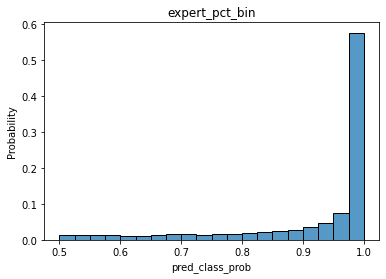

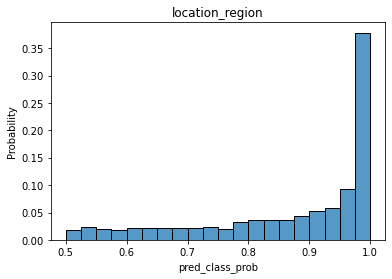

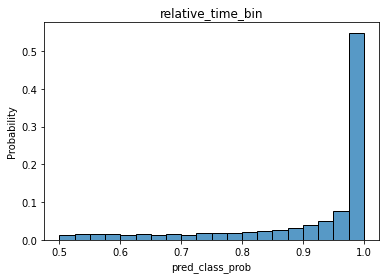

In [110]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
for group_i, data_i in reader_group_test_data.groupby('group_category'):
    sns.histplot(data=data_i, x='pred_class_prob', stat='probability', bins=20)
    plt.title(group_i)
    # plt.xlim([0.9, 1.0])
    plt.show()

Let's restrict to $p>0.95$ for each subgroup and see how the question generation models do on this subset of questions! Probably won't make a big difference.

In [127]:
import torch
full_test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas().drop(['source_ids', 'target_ids', 'attention_mask', 'subreddit_embed', 'text_embed', 'source_ids_reader_token', 'source_text_reader_token'], axis=1)
full_test_data.rename(columns={'reader_token_str' : 'reader_group', 'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
## add reader group categories
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
full_test_data = full_test_data.assign(**{
    'group_category' : full_test_data.loc[:, 'reader_group'].apply(reader_group_category_lookup.get)
})

In [128]:
## load generated text data
import gzip
text_only_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rb')))
reader_token_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rb')))
reader_attn_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/author_attention_layer=5_location=encoder_config=attnconcat/test_data_output_text.gz', 'rb')))
model_output_types = ['text_only_model', 'reader_token_model', 'reader_attn_model']
model_output_data = [text_only_output, reader_token_output, reader_attn_output]
full_test_data = full_test_data.assign(**{
    x : y
    for x,y in zip(model_output_types, model_output_data)
})
reader_full_test_data = full_test_data[full_test_data.loc[:, 'reader_group']!='UNK']

In [125]:
reader_group_test_data.loc[:, ['author', 'id', 'group_category', 'question_id']].drop_duplicates(['author', 'id', 'group_category', 'question_id']).shape[0]

31296

In [130]:
# rejoin data
author_id_vars = ['author', 'id', 'group_category', 'question_id']
reader_pred_test_data = pd.merge(
    reader_group_test_data, 
    reader_full_test_data.loc[:, author_id_vars + model_output_types],
    on=author_id_vars,
    how='inner',
)
print(reader_pred_test_data.shape)

(31296, 21)


In [ ]:
## compute overlap scores UGH
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import test_question_overlap
from test_question_generation import STOP_WORDS
# suppress BLEU error message
import warnings
warnings.filterwarnings('ignore')
word_embed_file = '../../data/embeddings/wiki-news-300d-1M.vec.gz'
model_output_types = [
    'text_only_model',
    'reader_token_model',
    'reader_attn_model'
]
from nlp.arrow_dataset import Dataset
extra_test_cols = ['reader_group_class', 'pred_class']
reader_pred_test_data_torch = Dataset.from_pandas(reader_pred_test_data.drop(extra_test_cols, axis=1))
reader_pred_test_data_torch.rename_column_('question', 'target_text')
text_overlap_score_data = []
for model_output_type_i in model_output_types:
    print(f'model={model_output_type_i}')
    overlap_score_data_i = test_question_overlap(
        reader_pred_test_data.loc[:, model_output_type_i].values,
        reader_pred_test_data_torch,
        word_embed_file=word_embed_file,
        stop_words=STOP_WORDS,
    )
    # fix column names
    overlap_score_data_i.rename(columns={
        c : f'{c}_model={model_output_type_i.replace("_model","")}'
        for c in overlap_score_data_i.columns
    }, inplace=True)
    text_overlap_score_data.append(overlap_score_data_i)
text_overlap_score_data = pd.concat(text_overlap_score_data, axis=1)

model=text_only_model
